<a href="https://colab.research.google.com/github/RoyMakary/Python-Projects/blob/main/ECG_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ECG ANOMALY DETECTION PROJECT
---


The original dataset for "ECG5000" is a 20-hour long ECG downloaded from Physionet. The name is BIDMC Congestive Heart Failure Database(chfdb) and it is record "chf07". It was originally published in "Goldberger AL, Amaral LAN, Glass L, Hausdorff JM, Ivanov PCh, Mark RG, Mietus JE, Moody GB, Peng C-K, Stanley HE. PhysioBank, PhysioToolkit, and PhysioNet: Components of a New Research Resource for Complex Physiologic Signals. Circulation 101(23)". The data was pre-processed in two steps: (1) extract each heartbeat, (2) make each heartbeat equal length using interpolation. This dataset was originally used in paper "A general framework for never-ending learning from time series streams", DAMI 29(6). After that, 5,000 heartbeats were randomly selected. The patient has severe congestive heart failure and the class values were obtained by automated annotation.

---


In [49]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Mar 26 12:03:24 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0              39W / 300W |    460MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [50]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


#Loading the data & packages

In [51]:
from scipy.io import arff

In [52]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from IPython.display import Image, display
from glob import glob
import time
import copy
import shutil
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.switch_backend('agg')
from matplotlib import rcParams
import pandas as pd
import gdown


import torch
from torch import nn, optim

import torch.nn.functional as F
from torchvision import datasets, transforms, models

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [53]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The data comes in multiple formats. We’ll load the arff files into Pandas data frames:

In [54]:
arff_file_path = '/content/drive/MyDrive/Python data sets/ECG5000/ECG5000_TRAIN.arff'

with open(arff_file_path, 'r') as f:
    data, meta = arff.loadarff(f)

train = pd.DataFrame(data)

train.head()

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att132,att133,att134,att135,att136,att137,att138,att139,att140,target
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,b'1'
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,b'1'
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,b'1'
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,b'1'
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,b'1'


In [55]:
arff_file_path = '/content/drive/MyDrive/Python data sets/ECG5000/ECG5000_TEST.arff'

with open(arff_file_path, 'r') as f:
    data, meta = arff.loadarff(f)

test = pd.DataFrame(data)

test.head()

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att132,att133,att134,att135,att136,att137,att138,att139,att140,target
0,3.690844,0.711414,-2.114091,-4.141007,-4.574472,-3.431909,-1.950791,-1.107067,-0.632322,0.334577,...,0.022847,0.188937,0.480932,0.629250,0.577291,0.665527,1.035997,1.492287,-1.905073,b'1'
1,-1.348132,-3.996038,-4.226750,-4.251187,-3.477953,-2.228422,-1.808488,-1.534242,-0.779861,-0.397999,...,1.570938,1.591394,1.549193,1.193077,0.515134,0.126274,0.267532,1.071148,-1.164009,b'1'
2,1.024295,-0.590314,-1.916949,-2.806989,-3.527905,-3.638675,-2.779767,-2.019031,-1.980754,-1.440680,...,0.443502,0.827582,1.237007,1.235121,1.738103,1.800767,1.816301,1.473963,1.389767,b'1'
3,0.545657,-1.014383,-2.316698,-3.634040,-4.196857,-3.758093,-3.194444,-2.221764,-1.588554,-1.202146,...,0.777530,1.119240,0.902984,0.554098,0.497053,0.418116,0.703108,1.064602,-0.044853,b'1'
4,0.661133,-1.552471,-3.124641,-4.313351,-4.017042,-3.005993,-1.832411,-1.503886,-1.071705,-0.521316,...,1.280823,1.494315,1.618764,1.447449,1.238577,1.749692,1.986803,1.422756,-0.357784,b'1'


We’ll combine the training and test data into a single data frame. This will give us more data to train our Autoencoder. We’ll also shuffle it:

In [56]:
df = train.append(test)
df = df.sample(frac=1.0)
df.shape

<ipython-input-56-0687e4e5ac46>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = train.append(test)


(5000, 141)

We have 5,000 examples. Each row represents a single heartbeat record. Let’s name the possible classes:

##We have 5 types of hearbeats (classes):

Normal (N)\
R-on-T Premature Ventricular Contraction (R-on-T PVC)\
Premature Ventricular Contraction (PVC)\
Supra-ventricular Premature or Ectopic Beat (SP or EB)\
Unclassified Beat (UB).

---

## Data preprocessing

In [57]:
CLASS_NORMAL = 1
class_names = ['Normal','R on T','PVC','SP','UB']

In [58]:
new_columns = list(df.columns)
new_columns[-1] = 'target'
df.columns = new_columns

In [59]:
df.head()

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att132,att133,att134,att135,att136,att137,att138,att139,att140,target
1001,1.469756,-1.048520,-3.394356,-4.254399,-4.162834,-3.822570,-3.003609,-1.799773,-1.500033,-1.025095,...,0.945178,1.275588,1.617218,1.580279,1.306195,1.351674,1.915517,1.672103,-1.039932,b'1'
2086,-1.998602,-3.770552,-4.267091,-4.256133,-3.515288,-2.554540,-1.699639,-1.566366,-1.038815,-0.425483,...,1.008577,1.024698,1.051141,1.015352,0.988475,1.050191,1.089509,1.465382,0.799517,b'1'
2153,-1.187772,-3.365038,-3.695653,-4.094781,-3.992549,-3.425381,-2.057643,-1.277729,-1.307397,-0.623098,...,1.085007,1.467196,1.413850,1.283822,0.923126,0.759235,0.932364,1.216265,-0.824489,b'1'
555,0.604969,-1.671363,-3.236131,-3.966465,-4.067820,-3.551897,-2.582864,-1.804755,-1.688151,-1.025897,...,0.545222,0.649363,0.986846,1.234495,1.280039,1.215985,1.617971,2.196543,0.023843,b'1'
205,-1.197203,-3.270123,-3.778723,-3.977574,-3.405060,-2.392634,-1.726322,-1.572748,-0.920075,-0.388731,...,0.828168,0.914338,1.063077,1.393479,1.469756,1.392281,1.144732,1.668263,1.734676,b'1'


# Exploratory Data Analysis

Let’s check how many examples for each heartbeat class do we have:

In [60]:
df.target.value_counts()

b'1'    2919
b'2'    1767
b'4'     194
b'3'      96
b'5'      24
Name: target, dtype: int64

<ipython-input-61-65e57fa78aad>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='target', data=df, palette='Set1')


[Text(0, 0, 'Normal'),
 Text(1, 0, 'R on T'),
 Text(2, 0, 'PVC'),
 Text(3, 0, 'SP'),
 Text(4, 0, 'UB')]

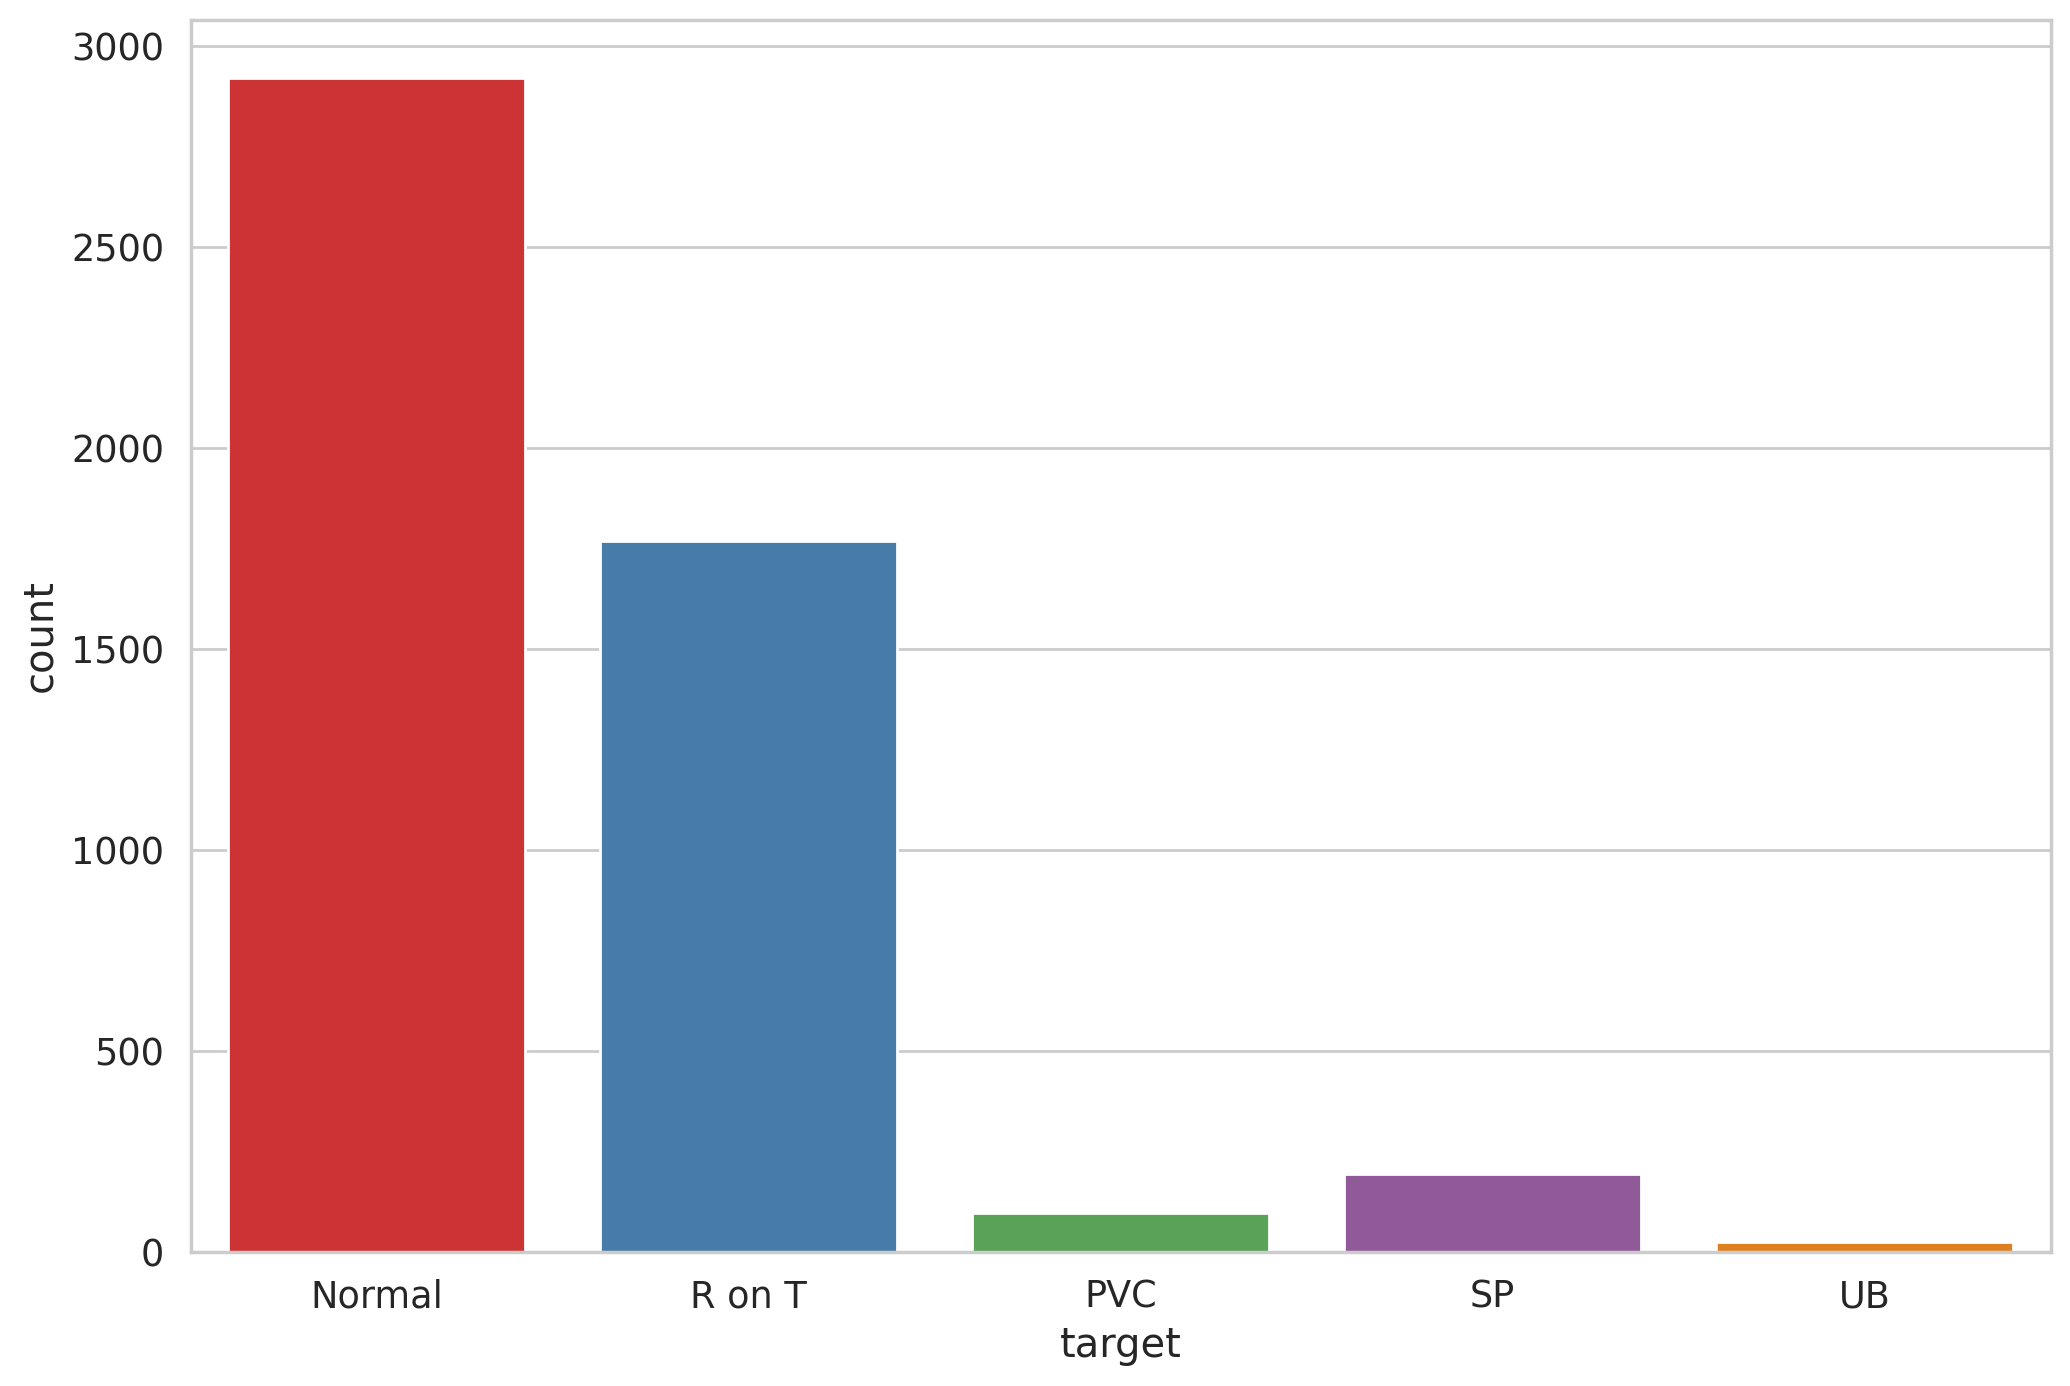

In [61]:
# Create the countplot
df['target'] = df['target'].astype('category')
ax = sns.countplot(x='target', data=df, palette='Set1')
ax.set_xticks(range(len(class_names)))
ax.set_xticklabels(class_names)

In [62]:
def plot_time_series_class(data, class_name, ax, n_steps=10):
  # Convert input data to a Pandas DataFrame
  time_series_df = pd.DataFrame(data)

  # Calculate the rolling mean (smooth path) and rolling standard deviation (path deviation)
  smooth_path = time_series_df.rolling(n_steps).mean()
  path_deviation = 2 * time_series_df.rolling(n_steps).std()

  # Calculate upper and lower bounds for the shaded area
  under_line = (smooth_path - path_deviation)[0]
  over_line = (smooth_path + path_deviation)[0]

  # Plot the smooth path
  ax.plot(smooth_path, linewidth=2)

  # Fill the area between the upper and lower bounds with a translucent color
  ax.fill_between(
      path_deviation.index,
      under_line,
      over_line,
      alpha =.125
  )
  ax.set_title(class_name)

In [63]:
df[df.target == str(CLASS_NORMAL)] \
    .drop(labels='target', axis=1) \
    .mean(axis=0) \
    .to_numpy().shape

(140,)

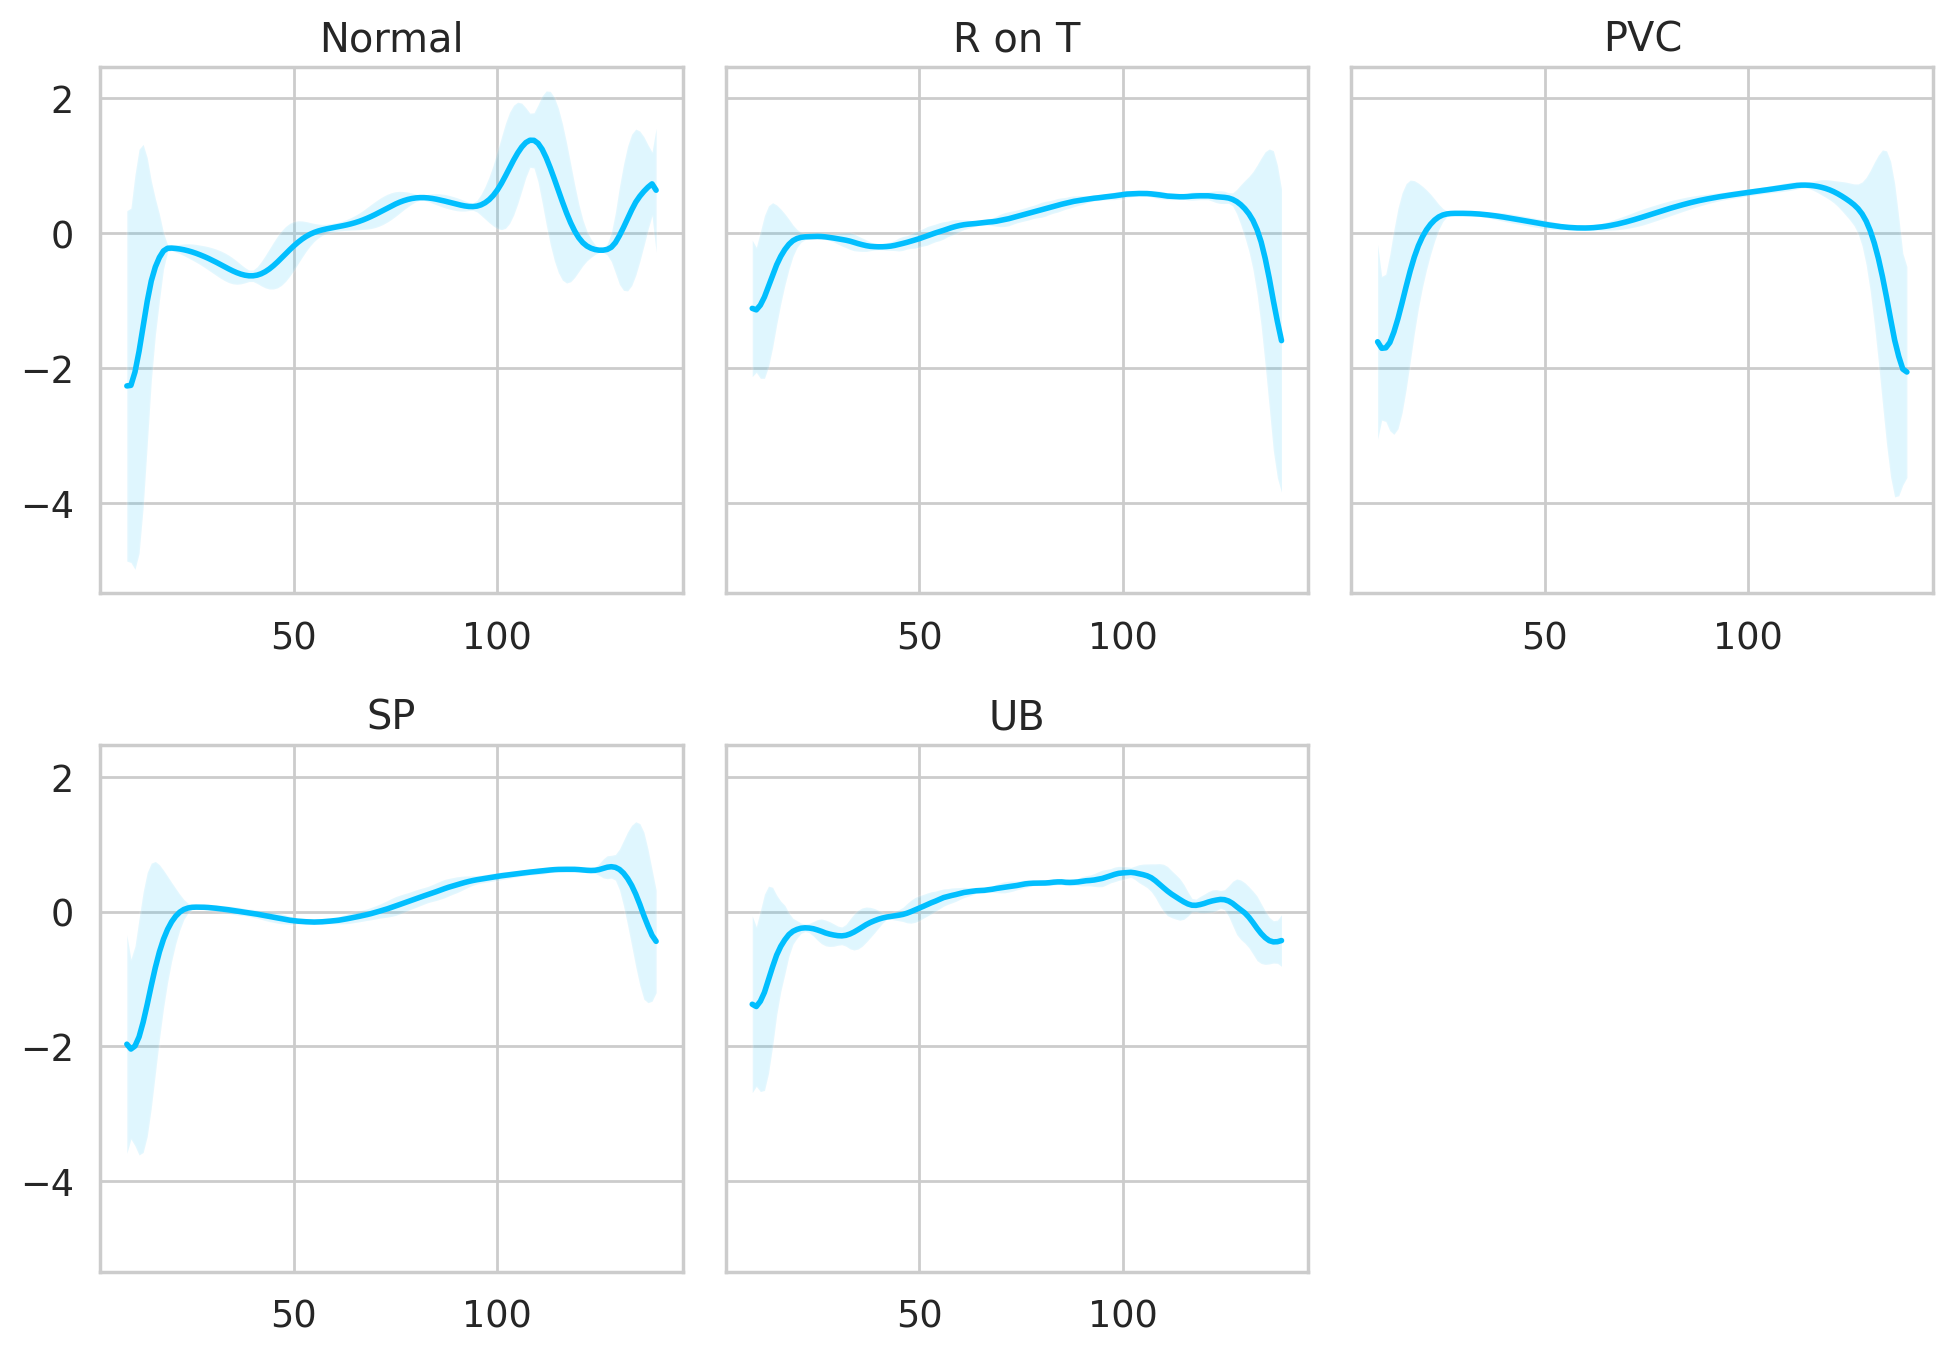

In [64]:
# Get unique classes from the 'target' column in the DataFrame
classes = df.target.unique()

# Create subplots based on the number of unique classes
fig, axs = plt.subplots(
    nrows=len(classes) // 3 +1, # Calculate the number of rows for subplots
    ncols=3,  # Fixed number of columns for subplots
    sharey=True,  # Share the y-axis among subplots for consistent scaling
    figsize=(10,7)
)

# Iterate over each class and create a subplot
for i, cls in enumerate(classes):
  ax = axs.flat[i]  # Access the current subplot
  # Extract data for the current class, drop the 'target' column, calculate the mean along the rows, and convert to NumPy array
  data = df[df.target == cls] \
    .drop(labels='target', axis=1) \
    .mean(axis=0) \
    .to_numpy()
  plot_time_series_class(data, class_names[i], ax)

fig.delaxes(axs.flat[-1]) # Remove the last subplot if there are more subplots than needed
fig.tight_layout(); # Adjust the layout for a clean appearance

It is very good that the normal class has a distinctly different pattern than all other classes.\
So maybe our model will be able to detect anomalies?

# LSTM Autoencoder
------

The Autoencoder’s job is to get some input data, pass it through the model, and obtain a reconstruction of the input. The reconstruction should match the input as much as possible. The trick is to use a small number of parameters, so your model learns a compressed representation of the data.

In a sense, Autoencoders try to learn only the most important features (compressed version) of the data. Here, we’ll have a look at how to feed Time Series data to an Autoencoder. We’ll use a couple of LSTM layers (hence the LSTM Autoencoder) to capture the temporal dependencies of the data.

To classify a sequence as normal or an anomaly, we’ll pick a threshold above which a heartbeat is considered abnormal.

## Reconstruction Loss

When training an Autoencoder, the objective is to reconstruct the input as best as possible. This is done by minimizing a loss function (just like in supervised learning). This function is known as reconstruction loss. Cross-entropy loss and Mean squared error are common examples.

##Anomaly Detection in ECG Data
We’ll use normal heartbeats as training data for our model and record the reconstruction loss. But first, we need to prepare the data:

##Data preprocessing

Let's get all the normal heartbeats and drop the target (class) column:

In [65]:
df['target'] = df['target'].str.decode('utf-8').str.strip()
normal_df = df[df['target'] == str(CLASS_NORMAL)].drop(labels='target', axis=1).reset_index(drop=True)

In [66]:
normal_df.shape

(2919, 140)

In [67]:
anomaly_df = df[df['target'] != str(CLASS_NORMAL)].drop(labels='target', axis=1).reset_index(drop=True)

In [68]:
anomaly_df.shape

(2081, 140)

We’ll split the normal examples into train, validation and test sets:

In [69]:
train_df, val_df = train_test_split(normal_df, test_size=0.15, random_state=RANDOM_SEED)

In [70]:
val_df, test_df = train_test_split(val_df, test_size=0.33, random_state=RANDOM_SEED)

We need to convert our examples into tensors, so we can use them to train our Autoencoder. \
Let’s write a helper function for that:

In [71]:
def create_dataset(df):
    # Convert DataFrame to a list of sequences, each represented as a list of float values
    sequences = df.astype(np.float32).to_numpy().tolist()

    # Convert the list of sequences to a list of PyTorch tensors
    # Each sequence tensor is of shape (seq_len, 1, n_features)
    dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]

    # Stack the sequence tensors to create a 3D tensor representing the entire dataset
    # The resulting shape is (n_seq, seq_len, n_features)
    n_seq, seq_len, n_features = torch.stack(dataset).shape

    # Return the dataset, sequence length, and number of features
    return dataset, seq_len, n_features

Each Time Series will be converted to a 2D Tensor in the shape sequence length x number of features (140x1 in our case).

Let's create some data sets:

In [72]:
train_dataset, seq_len, n_features = create_dataset(train_df)
val_dataset, _, _ = create_dataset(val_df)
test_normal_dataset, _, _ = create_dataset(test_df)
test_anomaly_dataset, _, _ = create_dataset(anomaly_df)

#Building the LSTM Autoencoder
---
The general Autoencoder architecture consists of two components. An Encoder that compresses the input and a Decoder that tries to reconstruct it.

We’ll use the LSTM Autoencoder from this GitHub repo (https://github.com/shobrook/sequitur) with some small tweaks. Our model’s job is to reconstruct Time Series data. Let’s start with the Encoder:

We are basically training on the normal heartbeats and our auto-encoder is going to understand what normal heatbeats look like and then we are going to pass in some heartbeats that are anomalies and our auto-encoder won't be able to reconstruct those heartbats.

And then by measuring the reconstruction error, when it high we thus might say that it is an anomaly.


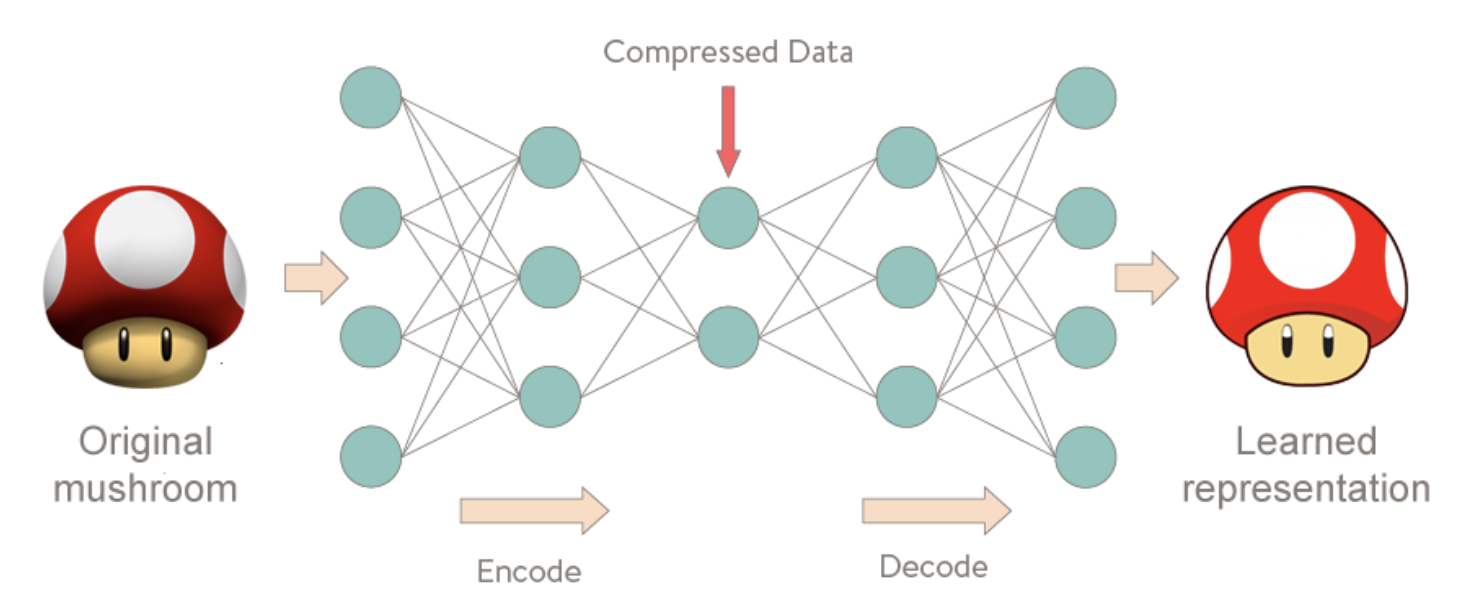

In [73]:
image_path_1 = '/content/drive/MyDrive/Python data sets/ECG5000/Screenshot 2024-03-11 at 10.54.02 PM.png'
display(Image(filename=image_path_1))

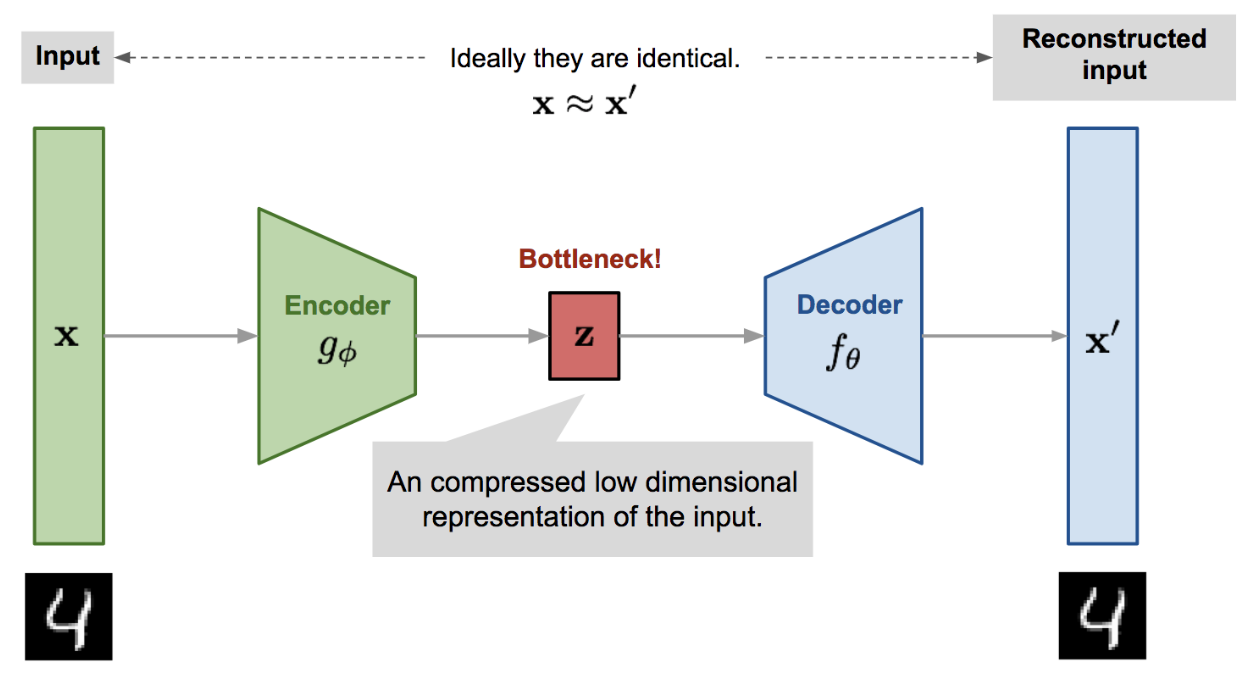

In [74]:
image_path_2 = '/content/drive/MyDrive/Python data sets/ECG5000/Screenshot 2024-03-11 at 6.43.34 PM.png'
display(Image(filename=image_path_2))

These are the step of the encoder class:

- Input Parameters: initialize and store the input parameters for sequence length, number of features, embedding dimension, and hidden dimension.
- LSTM Layers: define two LSTM layers using PyTorch's nn.LSTM module with specified input and hidden sizes, one for each layer.
- Forward Method: define the forward method for the Encoder class. This method specifies how input data flows through the layers of the model.
- Reshape Input Tensor: reshape the input tensor to match the expected shape for the LSTM layer.
- Pass through LSTM Layers: pass the reshaped input through the two LSTM layers. The hidden states and outputs are captured.
- Reshape Final Hidden State: reshape the final hidden state and return it. This hidden state represents the encoded information from the input sequence.

In [75]:
class Encoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(Encoder, self).__init__()

        # Define input parameters
        self.seq_len, self.n_features = seq_len, n_features
        self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

        # First LSTM layer
        self.rnn1 = nn.LSTM(
            input_size=n_features,
            hidden_size=self.hidden_dim,
            num_layers=1,
            batch_first=True
        )

        # Second LSTM layer
        self.rnn2 = nn.LSTM(
            input_size=self.hidden_dim,
            hidden_size=embedding_dim,
            num_layers=1,
            batch_first=True
        )

    def forward(self, x):
        # Reshape input tensor to match LSTM input shape
        x = x.reshape((1, self.seq_len, self.n_features))

        # Pass through the first LSTM layer
        x, (_, _) = self.rnn1(x)

        # Pass through the second LSTM layer
        x, (hidden_n, _) = self.rnn2(x)

        # Reshape the final hidden state
        return hidden_n.reshape((self.n_features, self.embedding_dim))

Next, we’ll decode the compressed representation using a Decoder:\
These are the steps of the Decoder class:
- Input Parameters: initialize and store the input parameters for sequence length, input dimension, hidden dimension, and number of features.
- LSTM Layers: define two LSTM layers using PyTorch's nn.LSTM module with specified input and hidden sizes.
- Output Layer: define a linear (fully connected) output layer to produce the final decoded output.
- Forward Method: define the forward method for the Decoder class. This method specifies how input data flows through the layers of the model.
- Repeat Input Tensor: repeat the input tensor along the sequence length dimension.
- Reshape Input Tensor: reshape the input tensor to match the expected shape for the LSTM layer.
- Pass through LSTM Layers: pass the reshaped input through the two LSTM layers.
- Reshape Output Tensor: reshape the output tensor.
- Pass through Output Layer: pass the reshaped tensor through the linear output layer to produce the final decoded output.



In [76]:
class Decoder(nn.Module):
    def __init__(self, seq_len, input_dim=64, n_features=1):
        super(Decoder, self).__init__()

        # Define input parameters
        self.seq_len, self.input_dim = seq_len, input_dim
        self.hidden_dim, self.n_features = 2 * input_dim, n_features

        # LSTM layers
        self.rnn1 = nn.LSTM(
            input_size=input_dim,
            hidden_size=input_dim,
            num_layers=1,
            batch_first=True
        )
        self.rnn2 = nn.LSTM(
            input_size=input_dim,
            hidden_size=self.hidden_dim,
            num_layers=1,
            batch_first=True
        )

        # Output layer
        self.output_layer = nn.Linear(self.hidden_dim, n_features)

    def forward(self, x):
        # Repeat input tensor along the sequence length dimension
        x = x.repeat(self.seq_len, self.n_features)

        # Reshape input tensor to match LSTM input shape
        x = x.reshape((self.n_features, self.seq_len, self.input_dim))

        # Pass through the first LSTM layer
        x, (hidden_n, cell_n) = self.rnn1(x)

        # Pass through the second LSTM layer
        x, (hidden_n, cell_n) = self.rnn2(x)

        # Reshape the output tensor
        x = x.reshape((self.seq_len, self.hidden_dim))

        # Pass through the output layer
        return self.output_layer(x)

Let's put everything into an easy to use model:

In [77]:
class RecurrentAutoencoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(RecurrentAutoencoder, self).__init__()

        # Initialize encoder and decoder
        self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
        self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)

    def forward(self, x):
        # Pass input through the encoder
        x = self.encoder(x)

        # Pass the encoded representation through the decoder
        x = self.decoder(x)

        # Return the reconstructed output
        return x

Our Autoencoder passes the input through the Encoder and Decoder. Let’s create an instance of it:

In [78]:
model = RecurrentAutoencoder(seq_len, n_features, 128)
model = model.to(device)

#Training

Let’s write a helper function for our training process:

In [79]:
def train_model(model, train_dataset, val_dataset, n_epochs):
    # Optimizer and loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.L1Loss(reduction='sum').to(device)

    # History to store training and validation losses
    history = dict(train=[], val=[])

    # Initialize best model weights and loss
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 10000.0

    # Training loop
    for epoch in range(1, n_epochs + 1):
        # Set the model to training mode
        model = model.train()
        train_losses = []

        # Training phase
        for seq_true in train_dataset:
            # Zero the gradients
            optimizer.zero_grad()
            # Move data to the specified device (e.g., GPU)
            seq_true = seq_true.to(device)
            # Forward pass
            seq_pred = model(seq_true)
            # Calculate the loss
            loss = criterion(seq_pred, seq_true)
            # Backward pass and optimization step
            loss.backward()
            optimizer.step()
            # Append the loss to the list
            train_losses.append(loss.item())

        # Validation phase
        val_losses = []
        # Set the model to evaluation mode
        model = model.eval()
        with torch.no_grad():
            for seq_true in val_dataset:
                seq_true = seq_true.to(device)
                seq_pred = model(seq_true)
                loss = criterion(seq_pred, seq_true)
                val_losses.append(loss.item())

        # Calculate average losses for training and validation
        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)

        # Update history
        history['train'].append(train_loss)
        history['val'].append(val_loss)

        # Check for improvement in validation loss
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

        # Print epoch-wise training and validation losses
        print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

    # Load the best model weights
    model.load_state_dict(best_model_wts)

    # Set the model to evaluation mode
    return model.eval(), history

At each epoch, the training process feeds our model with all training examples and evaluates the performance on the validation set. Note that we’re using a batch size of 1 (our model sees only 1 sequence at a time). We also record the training and validation set losses during the process.

Note that we’re minimizing the L1Loss, which measures the MAE (mean absolute error). Why? The reconstructions seem to be better than with MSE (mean squared error).

We’ll get the version of the model with the smallest validation error. Let’s do some training:

In [80]:
model, history = train_model(
  model,
  train_dataset,
  val_dataset,
  n_epochs=150
)

Epoch 1: train loss 93.3309475807642 val loss 94.30115381442646
Epoch 2: train loss 59.84113183073438 val loss 55.07800813746534
Epoch 3: train loss 53.06001258751694 val loss 48.131366033196045
Epoch 4: train loss 41.5749353618691 val loss 32.29193524695908
Epoch 5: train loss 32.59360445838261 val loss 36.13583979427611
Epoch 6: train loss 29.8138454595625 val loss 30.082507781201254
Epoch 7: train loss 27.91776534868123 val loss 28.55728605094623
Epoch 8: train loss 27.14873329740722 val loss 25.079076936220552
Epoch 9: train loss 25.740006592906997 val loss 26.30022620829299
Epoch 10: train loss 25.293961258195957 val loss 23.67612685115671
Epoch 11: train loss 24.31584286526392 val loss 22.71547550552941
Epoch 12: train loss 23.534800323830744 val loss 23.021812155791924
Epoch 13: train loss 23.101102270074833 val loss 21.570676009402746
Epoch 14: train loss 22.00858754046931 val loss 19.685949419952497
Epoch 15: train loss 21.080728295636437 val loss 19.55842453953349
Epoch 16: t

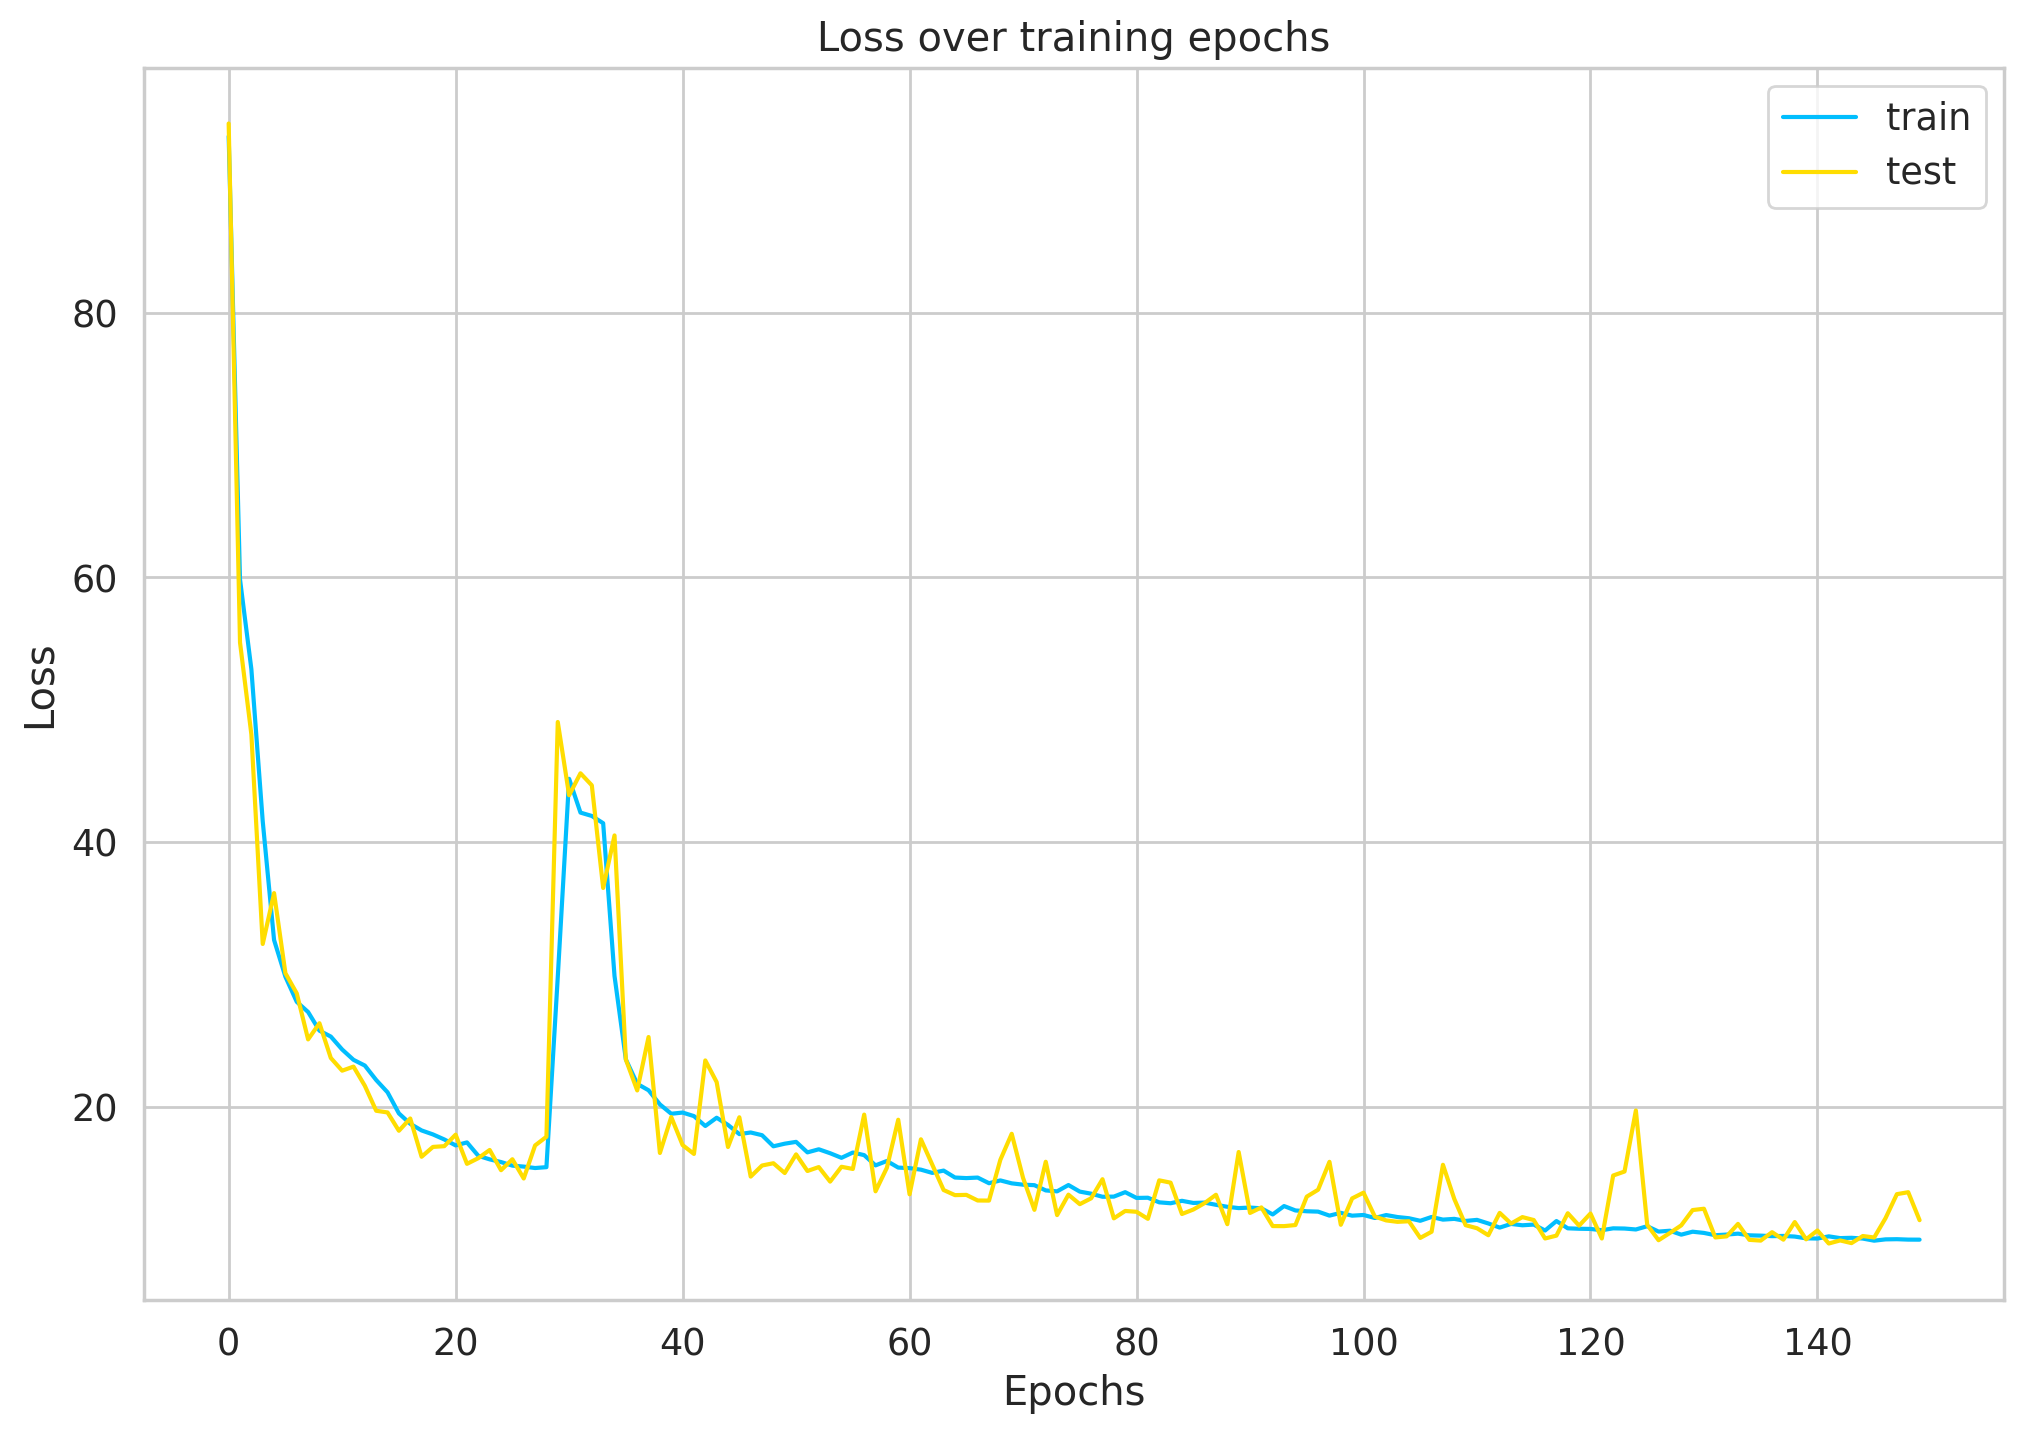

In [81]:
ax = plt.figure().gca() #getting current axis

ax.plot(history['train']) #Plotting the training data on the Axes (ax)
ax.plot(history['val']) #Plotting the validation data on the Axes (ax)
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(['train','test'])
plt.title('Loss over training epochs')
plt.show();

Our model converged quite well. Seems like we might’ve needed a larger validation set to smoothen the results, but that’ll do for now.

#Saving the model

Let’s store the model for later use:

In [82]:
MODEL_PATH = 'model.pth'
torch.save(model, MODEL_PATH)

# loaded_model = torch.load(MODEL_PATH) # Use this code to use the model when needed

# Choosing a threshold

With our model at hand, we can have a look at the reconstruction error on the training set.

Let’s start by writing a helper function to get predictions from our model:

In [83]:
# Defining a function for making predictions using a PyTorch model
def predict(model, dataset):
    # Lists to store predictions and losses
    predictions, losses = [], []

    # Using the L1 loss function for measuring the difference between predicted and true sequences
    criterion = nn.L1Loss(reduction='sum').to(device)

    # Disabling gradient computation during prediction
    with torch.no_grad():
        # Setting the model to evaluation mode
        model = model.eval()

        # Iterating over each sequence in the dataset
        for seq_true in dataset:
            # Moving the true sequence to the specified device (e.g., GPU)
            seq_true = seq_true.to(device)

            # Forward pass to obtain the predicted sequence
            seq_pred = model(seq_true)

            # Calculating the L1 loss between predicted and true sequences
            loss = criterion(seq_pred, seq_true)

            # Appending the flattened predicted sequence to the predictions list
            predictions.append(seq_pred.cpu().numpy().flatten())

            # Appending the loss value to the losses list
            losses.append(loss.item())

    # Returning the predicted sequences and corresponding losses
    return predictions, losses

Our function goes through each example in the dataset and records the predictions and losses.

Let’s get the losses and have a look at them:

<Axes: ylabel='Count'>

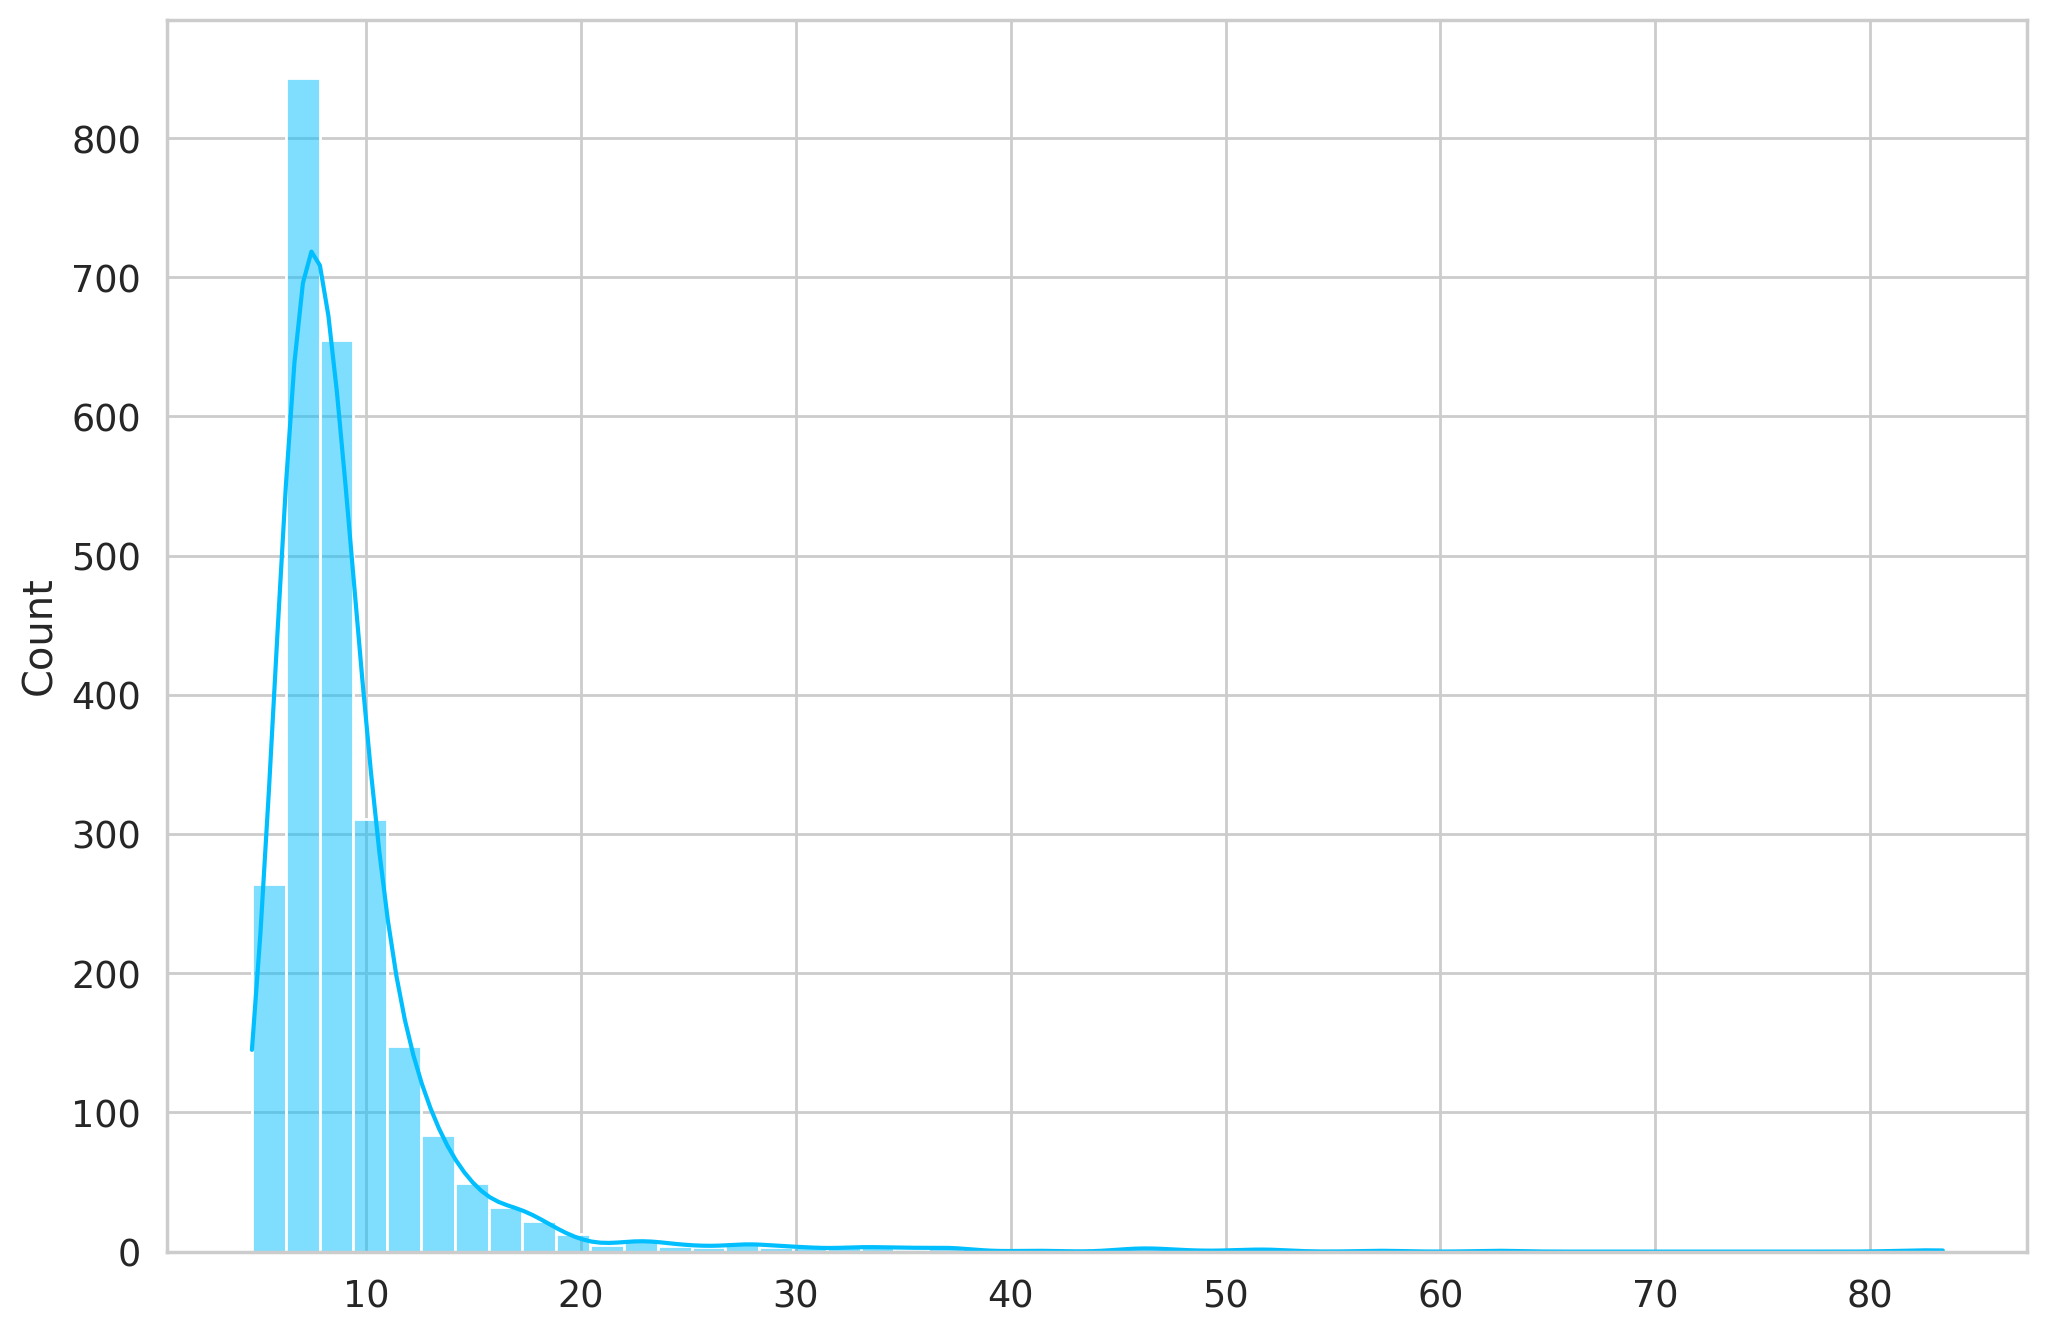

In [84]:
_, losses = predict(model, train_dataset)
sns.histplot(losses, bins=50, kde=True)

In [85]:
THRESHOLD = 26

#Evaluation
Using the threshold, we can turn the problem into a simple binary classification task:

If the reconstruction loss for an example is below the threshold, we’ll classify it as a normal heartbeat
Alternatively, if the loss is higher than the threshold, we’ll classify it as an anomaly



##Normal hearbeats
Let’s check how well our model does on normal heartbeats. We’ll use the normal heartbeats from the test set (our model haven’t seen those):

<Axes: ylabel='Count'>

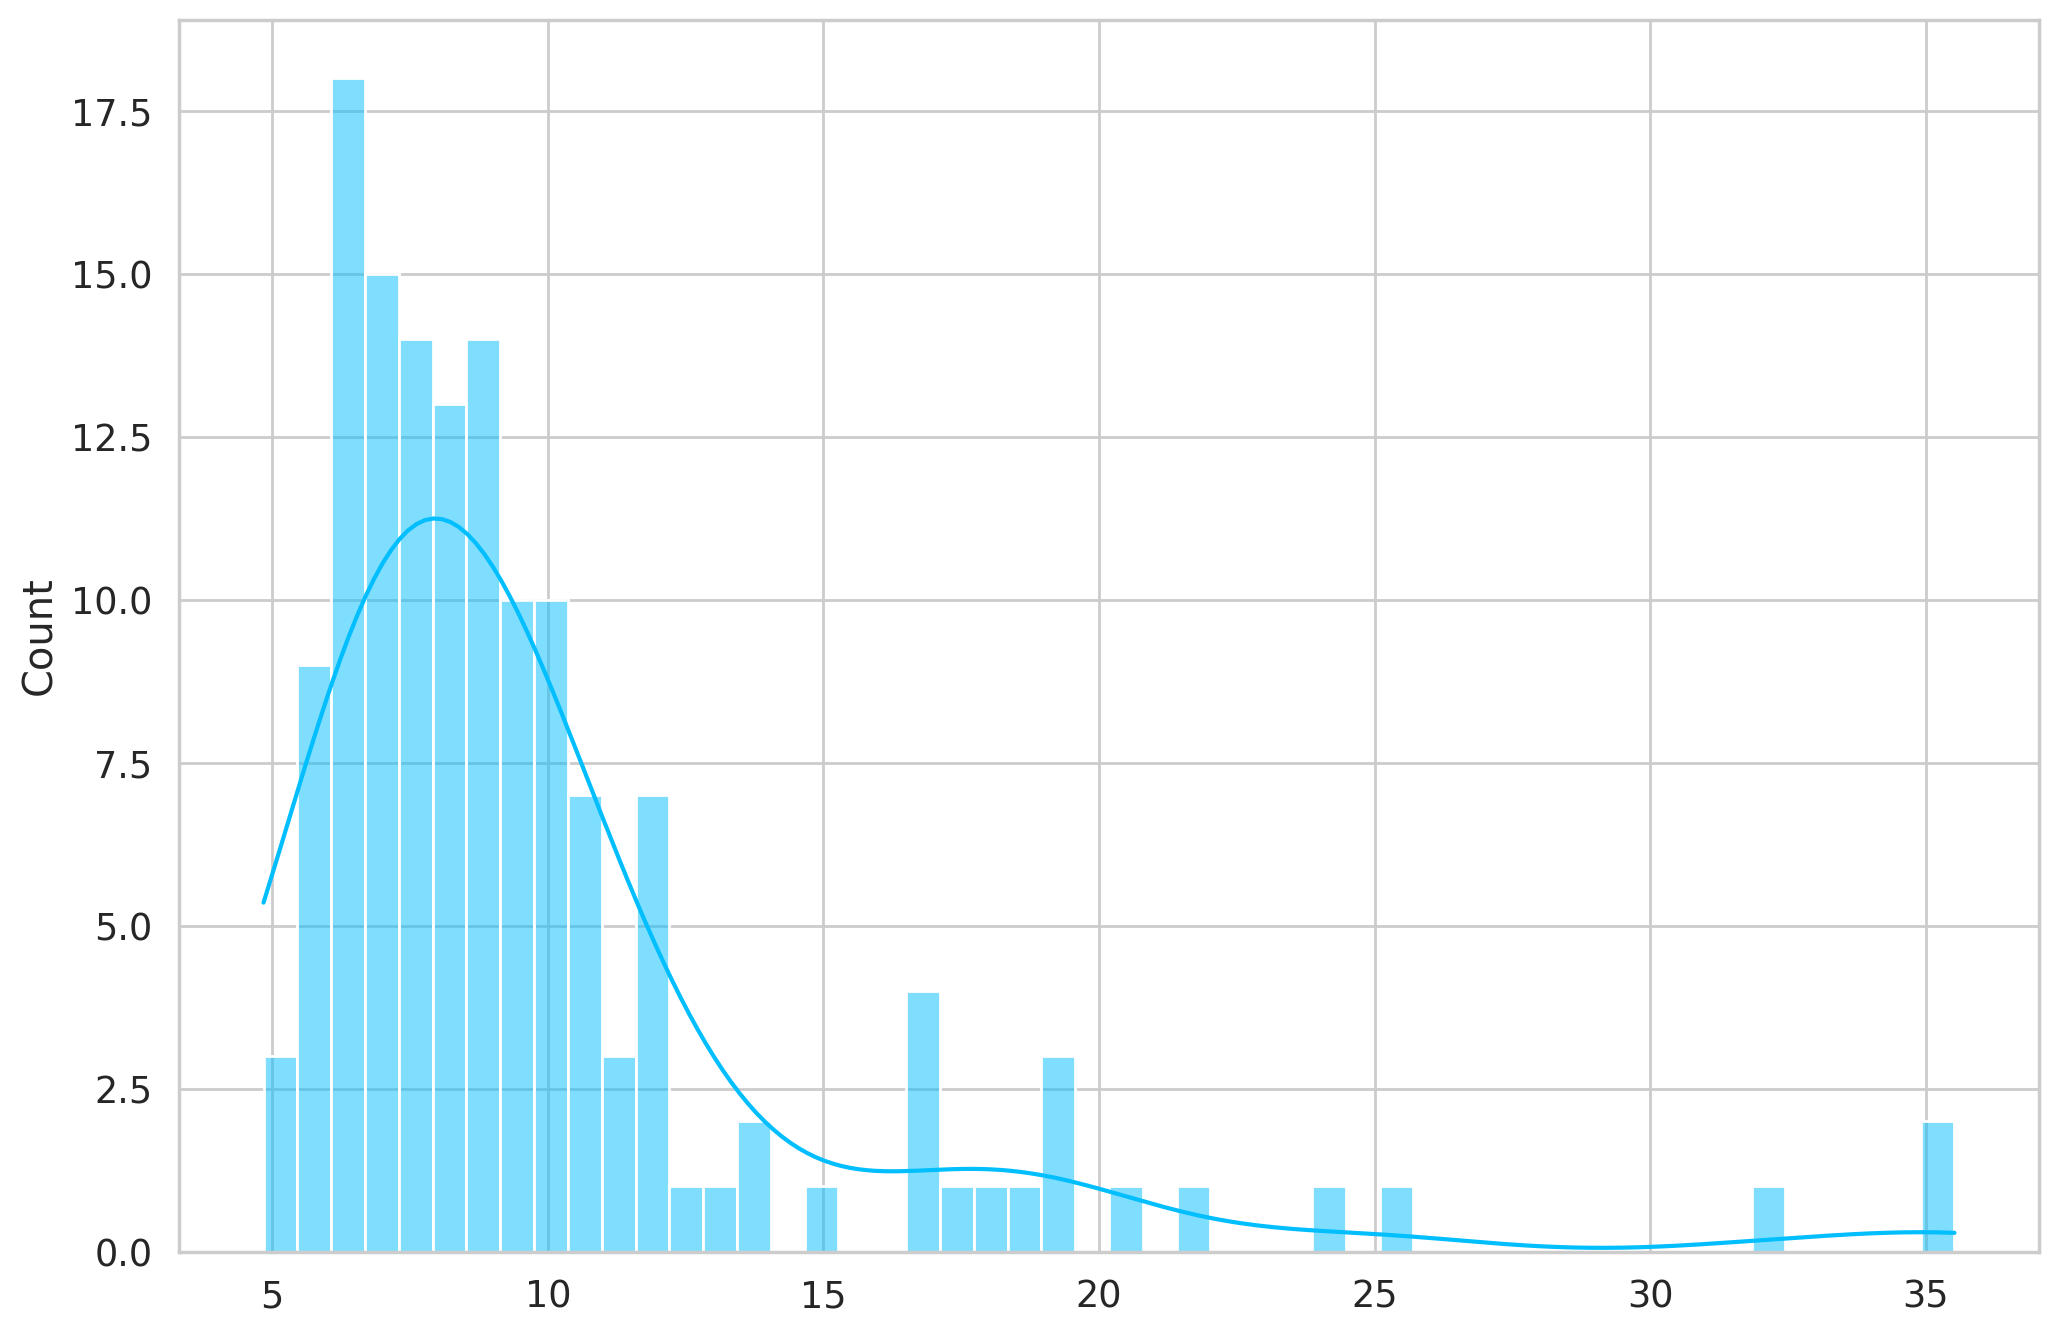

In [86]:
predictions, pred_losses = predict(model, test_normal_dataset)
sns.histplot(pred_losses, bins=50, kde=True)

We’ll count the correct predictions:

In [87]:
correct = sum(l <= THRESHOLD for l in pred_losses)
print(f'Correct normal predictions: {correct}/{len(test_normal_dataset)}')

Correct normal predictions: 142/145


## Anomalies

We’ll do the same with the anomaly examples, but their number is much higher. We’ll get a subset that has the same size as the normal heartbeats:

In [88]:
anomaly_dataset = test_anomaly_dataset[:len(test_normal_dataset)]

Now we can take the predictions of our model for the subset of anomalies:

<Axes: ylabel='Count'>

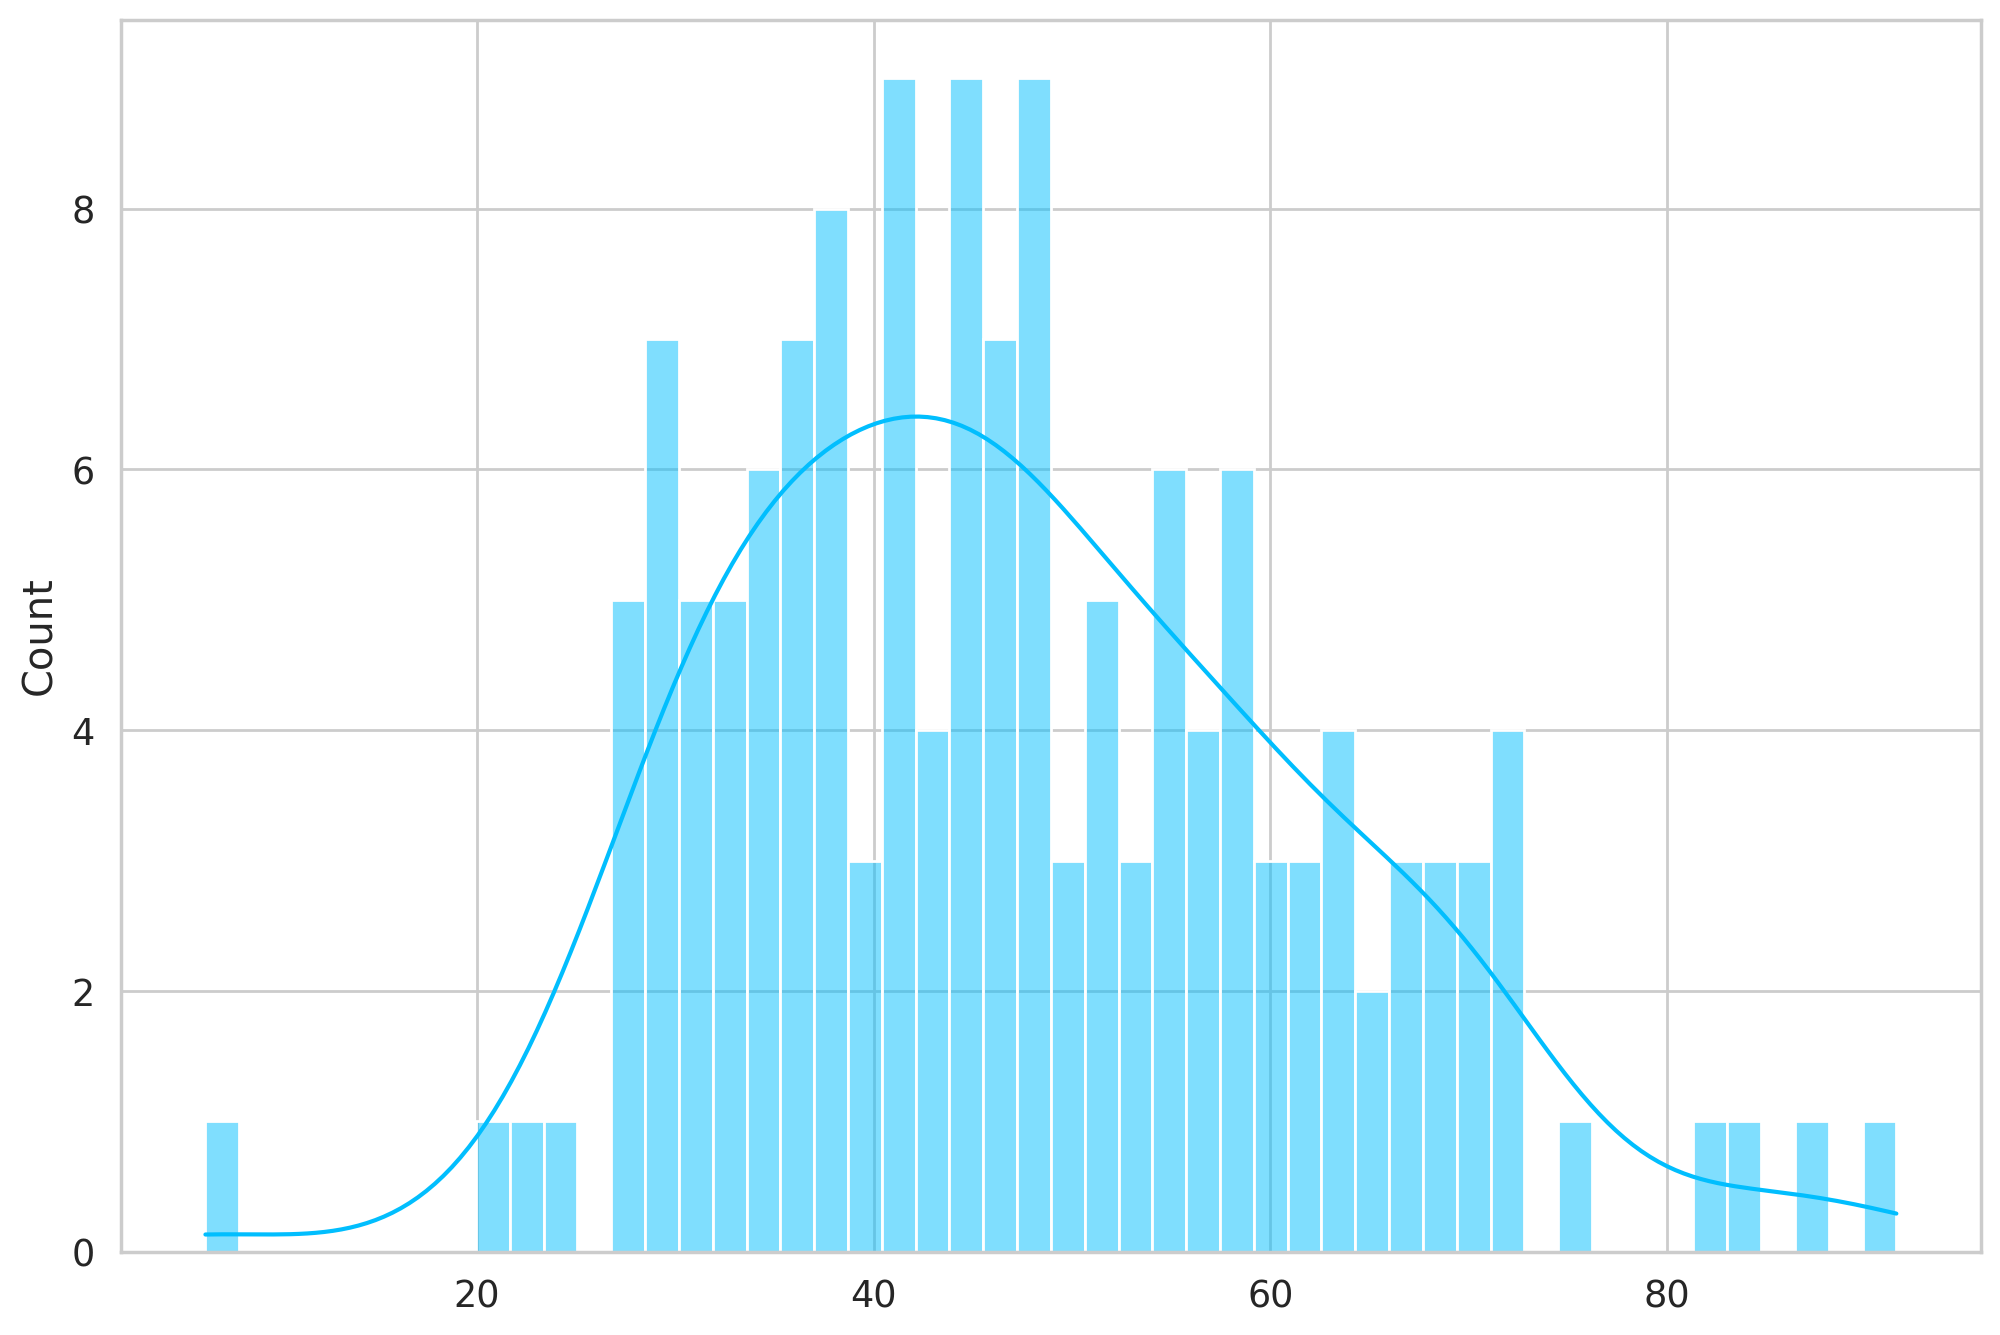

In [89]:
predictions, pred_losses = predict(model, anomaly_dataset)
sns.histplot(pred_losses, bins=50, kde=True)

In [90]:
correct = sum(l > THRESHOLD for l in pred_losses)
print(f'Correct anomaly predictions: {correct}/{len(anomaly_dataset)}')

Correct anomaly predictions: 141/145


We can overlay the real and reconstructed Time Series values to see how close they are.

We’ll do it for some normal and anomaly cases:

In [91]:
def plot_prediction(data, model, title, ax):
    predictions, pred_losses = predict(model, [data])
    ax.plot(data, label='True')
    ax.plot(predictions[0], label='Predicted')
    ax.set_title(f'{title} (loss: {np.around(pred_losses[0], 2)})')
    ax.legend()

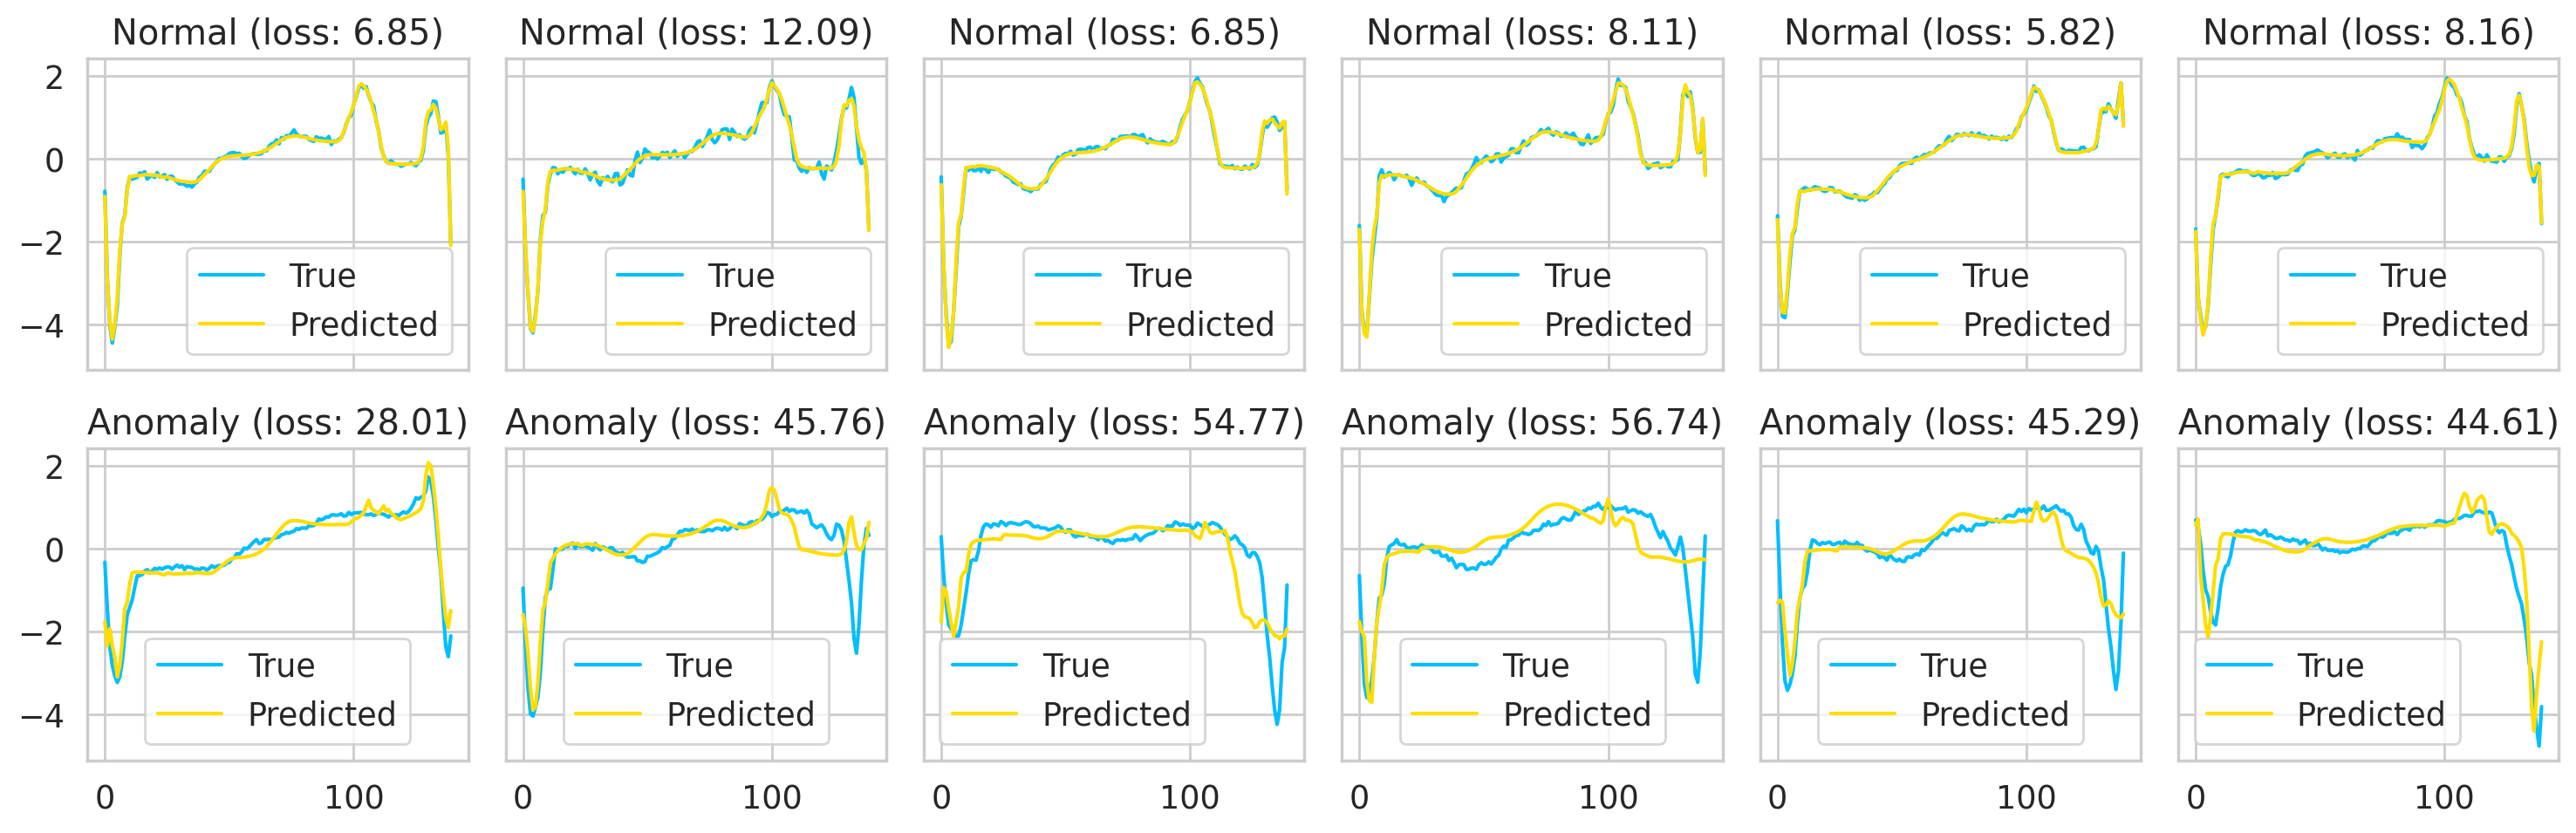

In [92]:
fig, axs = plt.subplots(
    nrows = 2, ncols = 6, sharex=True, sharey=True, figsize=(15,5)
)

for i, data in enumerate(test_normal_dataset[:6]):
  plot_prediction(data, model, title='Normal', ax=axs[0,i])

for i, data in enumerate(test_anomaly_dataset[:6]):
  plot_prediction(data, model, title='Anomaly', ax=axs[1,i])

fig.tight_layout();

# Summary

What we learned to do:
- Prepare a dataset for Anomaly Detection from Time Series Data
- Build an LSTM Autoencoder with PyTorch
- Train and evaluate your model
- Choose a threshold for anomaly detection
- Classify unseen examples as normal or anomaly

While our Time Series data is univariate (we have only 1 feature), the code should work for multivariate datasets (multiple features) with little or no modification. Feel free to try it!